In [2]:
from ptbxlae.dataprocessing.ptbxlDS import PtbxlDM
import pandas as pd
from tqdm.auto import tqdm

pd.options.mode.chained_assignment = None  # default='warn'

# Get Latent Representations

In [3]:
from ptbxlae.modeling.resnet1dVAE import Resnet1dVAE
import torch

dm = PtbxlDM(root_folder="../data")
dm.setup(stage="test")
dl = dm.test_dataloader()

m = Resnet1dVAE.load_from_checkpoint('../cache/savedmodels/best.ckpt').eval()
m.cpu()

latent_representations = torch.cat([m.encoder(x) for x in tqdm(dl)]).cpu().detach().numpy()


/home/isears/VirtualEnvironments/default/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


  0%|          | 0/48 [00:00<?, ?it/s]

In [4]:
latent_df = pd.DataFrame(data=latent_representations, columns=[f"latent.{i}" for i in range(0, 40)])
latent_df

,latent.0,latent.1,latent.2,latent.3,latent.4,latent.5,latent.6,latent.7,latent.8,latent.9,...,latent.30,latent.31,latent.32,latent.33,latent.34,latent.35,latent.36,latent.37,latent.38,latent.39
0,-0.479254,4.144479,2.629408,-3.738324,2.865951,-1.037815,2.866911,0.185309,-0.212494,0.787406,...,-3.350599,-3.479891,-3.164102,9.451683,-1.817839,0.029983,-1.431886,-0.086997,-1.959187,-0.885792
1,-0.507723,4.212573,2.686349,-3.804001,2.903163,-1.096167,2.967730,0.181597,-0.192388,0.836782,...,-3.422595,-3.497140,-3.202848,9.685384,-1.876650,0.061245,-1.414567,-0.109656,-1.939593,-0.903979
2,-0.453302,4.132789,2.601479,-3.725539,2.805857,-1.063451,2.873834,0.148936,-0.213909,0.779980,...,-3.329544,-3.442268,-3.139279,9.337317,-1.760483,0.067366,-1.411055,-0.087026,-1.926867,-0.901685
3,-0.507112,4.213818,2.664683,-3.834146,2.936141,-1.069752,2.945536,0.166492,-0.170598,0.836758,...,-3.381862,-3.524384,-3.215238,9.448286,-1.851499,0.046915,-1.442366,-0.089430,-1.979350,-0.917052
4,-0.456168,4.238237,2.664728,-3.772621,2.841174,-1.079715,2.935279,0.152836,-0.185708,0.813555,...,-3.360643,-3.466016,-3.174609,9.527425,-1.854777,0.083125,-1.414977,-0.099751,-1.964939,-0.942113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,-0.509666,3.065465,2.372228,-3.767767,2.615525,-0.405351,2.774291,-0.181855,0.131575,1.470162,...,-2.644046,-3.644579,-2.233362,7.680273,-1.786798,0.338488,-1.251252,-0.751520,-2.302368,0.108516
1501,-0.507506,4.233196,2.663616,-3.793637,2.909043,-1.099179,2.920096,0.156806,-0.207570,0.830850,...,-3.383648,-3.492449,-3.188935,9.594154,-1.844221,0.030270,-1.431948,-0.117461,-1.967407,-0.923236
1502,-0.548358,4.266070,2.749010,-3.898252,2.925400,-1.130527,3.067734,0.235324,-0.247237,0.862986,...,-3.492969,-3.607005,-3.314675,10.027288,-1.940516,0.110408,-1.454859,-0.091834,-1.974431,-0.878131
1503,-0.541768,4.243593,2.723260,-3.899348,2.885357,-1.110354,2.994468,0.206868,-0.204819,0.877431,...,-3.464034,-3.552405,-3.278874,9.814490,-1.897637,0.067004,-1.487045,-0.076958,-2.011602,-0.892648


# Util Function: LR Based on Latent Representations for Specified Targets (y)

In [6]:
# Util function to do a quick LR on a specified target based on latent variables
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def eval_predictive_power_binary_outcome(x, y):
    lr = LogisticRegression()

    ret = {
        "Total usable": len(y),
        "% positive": sum(y) / len(y)
    }

    if sum(y) < 10:  # Won't be able to do CV
        ret['Avg CV score'] = float('nan')
        return ret

    try:
        scores = cross_val_score(lr, x, y, cv=5, scoring='roc_auc')
        ret['Avg CV score'] = sum(scores) / len(scores)
        return ret
    except ValueError:
        ret['Avg CV score'] = float('nan')
        return ret

# Assess Predictive Power of Latent Representations for Each Diagnostic Label in PTB

In [7]:
import ast

dm = PtbxlDM(root_folder="../data")
dm.setup(stage="test")
metadata = dm.test_ds.dataset.metadata.iloc[dm.test_ds.indices].reset_index()

all_scps = pd.read_csv("../data/scp_statements.csv", index_col=0)

def ptb_val_to_pseudobinary_label(scp_code_of_interest: str, this_recording_scp_codes: str):
    if scp_code_of_interest not in this_recording_scp_codes.keys():
        return 0.0
    elif scp_code_of_interest in this_recording_scp_codes.keys() and this_recording_scp_codes[scp_code_of_interest] == 100.0:
        return 1.0
    else:
        return float('nan')

combined_df = pd.concat([metadata, latent_df], axis=1)

results = list()
for scp_code in tqdm(all_scps.index.to_list()):
    combined_df[f'scp.{scp_code}'] = combined_df['scp_codes'].apply(lambda codes: ptb_val_to_pseudobinary_label(scp_code, ast.literal_eval(codes)))
    relevant_df = combined_df[~combined_df[f'scp.{scp_code}'].isna()]

    res = eval_predictive_power_binary_outcome(relevant_df[latent_df.columns], relevant_df[f'scp.{scp_code}'])
    res['Target'] = all_scps.loc[scp_code]['description']
    results.append(res)


results_df = pd.DataFrame.from_records(results)
results_df.nlargest(n=50, columns=['Avg CV score'])


  0%|          | 0/71 [00:00<?, ?it/s]

/home/isears/VirtualEnvironments/default/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/isears/VirtualEnvironments/default/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

,Total usable,% positive,Avg CV score,Target
15,1505,0.021927,0.967201,complete left bundle branch block
64,1504,0.013963,0.811082,normal functioning artificial pacemaker
7,1439,0.050035,0.755963,left ventricular hypertrophy
21,1505,0.008638,0.748359,subendocardial injury in anteroseptal leads
4,1333,0.399850,0.748299,normal ECG
6,1451,0.062715,0.738612,anteroseptal myocardial infarction
9,1491,0.057009,0.731112,non-specific ischemic
17,1500,0.013333,0.660811,left atrial overload/enlargement
26,1504,0.009973,0.653188,subendocardial injury in anterolateral leads
13,1498,0.014686,0.652340,ischemic in anterolateral leads


# Assess Correlation of Latent Representations with Higher-Level ECG Features

In [8]:
import neurokit2 as nk

signals = torch.cat([x for x in tqdm(dl)]).cpu().detach().numpy()
signals.shape

  0%|          | 0/48 [00:02<?, ?it/s]

(1505, 12, 5000)

In [9]:
processed_sig, info = nk.ecg_process(signals[0,0,:], sampling_rate=500)
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 341,  717, 1096, 1470, 1845, 2224, 2605, 2997, 3393, 3794, 4197,
        4595, 4913]),
 'ECG_R_Peaks_Uncorrected': array([ 341,  717, 1096, 1470, 1845, 2224, 2605, 2997, 3393, 3794, 4197,
        4595, 4913]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([0.762, 0.752, 0.758, 0.748, 0.75 , 0.758, 0.762, 0.784, 0.792,
        0.802, 0.806, 0.796, 0.636]),
 'ECG_fixpeaks_drrs': array([ -1.00961538,  -0.96153846,   0.57692308,  -0.96153846,
          0.19230769,   0.76923077,   0.38461538,   2.11538462,
          0.76923077,   0.96153846,   0.38461538,  -0.96153846,
        -15.38461538]),
 'ECG_fixpeaks_mrrs': array([ 0.20710059, -0.35502959,  0.        , -0.59171598, -0.59171598,
        -0.23668639,  0.        ,  0.65088757,  0.56213018,  0.53254438,
         0.53254438,  0.1183

In [11]:
# Derive ECG characteristics util functions
import numpy as np
from enum import Enum

def extract_single_lead_features(sig_chan):
    assert len(sig_chan.shape) == 1

    ret = {
        'PR': float('nan'),
        'QRS': float('nan'),
        'QT': float('nan'),
        'Rate': float('nan'),
        'Rhythm': float('nan'),
        'Axis': float('nan')
    }

    try:
        processed_sig, info = nk.ecg_process(sig_chan, sampling_rate=500)
    except ValueError:
        return ret

    relevant_events = processed_sig[
        (
            (processed_sig['ECG_P_Onsets'] !=0) | \
            (processed_sig['ECG_Q_Peaks'] != 0) | \
            (processed_sig['ECG_S_Peaks'] != 0) | \
            (processed_sig['ECG_T_Offsets'] !=0)
        )
    ]

    class EVENT_TYPE(Enum):
        P_ONSET = 1
        Q_PEAK = 2
        S_PEAK = 3
        T_OFFSET = 4

    def get_event_type(row):
        if row['ECG_P_Onsets'] == 1:
            return EVENT_TYPE.P_ONSET
        elif row['ECG_Q_Peaks'] == 1:
            return EVENT_TYPE.Q_PEAK
        elif row['ECG_S_Peaks'] == 1:
            return EVENT_TYPE.S_PEAK
        elif row['ECG_T_Offsets'] == 1:
            return EVENT_TYPE.T_OFFSET
        else:
            raise ValueError(row)

    relevant_events.loc[:, 'Event_Type'] = relevant_events.apply(get_event_type, axis=1)

    pr_intervals = list()
    qrs_intervals = list()
    qt_intervals = list()

    # Stateful processing
    qrs_state = {}
    for tidx, curr_event in relevant_events['Event_Type'].to_dict().items():
        timestamp_ms = (tidx / 500) * 1000  # TODO: should pass freq (500) as param if use with other freq datasets

        # Any p-wave automatically resets to P wave seen state (State 0)
        if curr_event == EVENT_TYPE.P_ONSET:
            qrs_state = {
                EVENT_TYPE.P_ONSET: timestamp_ms
            }

        else:
            # State 1: P wave identified, expect Q wave
            if EVENT_TYPE.P_ONSET in qrs_state and not EVENT_TYPE.Q_PEAK in qrs_state and not EVENT_TYPE.S_PEAK in qrs_state:
                if curr_event == EVENT_TYPE.Q_PEAK:
                    qrs_state[EVENT_TYPE.Q_PEAK] = timestamp_ms
                else:  # Something unexpected, reset state
                    qrs_state = {}

            # State 2: P wave, Q wave identified, spect S wave
            elif EVENT_TYPE.Q_PEAK in qrs_state and not EVENT_TYPE.S_PEAK in qrs_state:
                if curr_event == EVENT_TYPE.S_PEAK:
                    qrs_state[EVENT_TYPE.S_PEAK] = timestamp_ms
                else:
                    qrs_state = {}

            # State 3: P wave, Q wave, S wave identified, expect T wave
            elif EVENT_TYPE.S_PEAK in qrs_state:
                if curr_event == EVENT_TYPE.T_OFFSET:
                    qrs_state[EVENT_TYPE.T_OFFSET] = timestamp_ms

                    # At this point, should have all necessary information to calculate features
                    pr_intervals.append(qrs_state[EVENT_TYPE.Q_PEAK] - qrs_state[EVENT_TYPE.P_ONSET])
                    qrs_intervals.append(qrs_state[EVENT_TYPE.S_PEAK] - qrs_state[EVENT_TYPE.Q_PEAK])
                    qt_intervals.append(qrs_state[EVENT_TYPE.T_OFFSET] - qrs_state[EVENT_TYPE.Q_PEAK])

                    # reset state
                    qrs_state = {}

                else:
                    qrs_state = {}

    assert len(pr_intervals) == len(qrs_intervals)
    assert len(qrs_intervals) == len(qt_intervals)

    
    for key, vals in zip(['PR', 'QRS', 'QT'], [pr_intervals, qrs_intervals, qt_intervals]):
        if len(pr_intervals) > 0:
            ret[key] = sum(vals) / len(vals)
        else:
            ret[key] = float('nan')


    # Rate
    # TODO: I think neurokit already does this through ecg_process, but documentation unclear
    rrs = list()
    for rpeak1, rpeak2 in zip(info['ECG_R_Peaks'], info['ECG_R_Peaks'][1:]):
        rrs.append((rpeak2 - rpeak1) / 500)

    avg_rr = sum(rrs) / len(rrs)
    ret['Rate'] = 60 / avg_rr

    # Rhythm
    # TODO

    # Axis
    # TODO

    return ret

def extract_single_ecg_features(channeled_signal):
    # Only get metrics for highest-quality lead
    def numeric_ecg_quality(s):
        quality_str = nk.ecg_quality(s, sampling_rate=500, method='zhao2018')

        if quality_str == 'Unacceptable':
            return 0
        elif quality_str == 'Barely acceptable':
            return 1
        elif quality_str == 'Excellent':
            return 2
        else:
            raise ValueError(quality_str)
        
    qualities = [numeric_ecg_quality(channeled_signal[idx]) for idx in range(0, channeled_signal.shape[0])]

    return extract_single_lead_features(channeled_signal[qualities.index(max(qualities)), :])

    

def extract_ecg_features(batched_ecgs):
    # expecting shape batch x channel x signal_len
    return pd.DataFrame.from_records(
        data=[
            extract_single_ecg_features(batched_ecgs[batch_idx, :, :])
            for batch_idx in tqdm(range(0, batched_ecgs.shape[0]))
        ]
    )


In [12]:
import os

if os.path.isfile("../cache/ecg_derived.parquet"):
    print("[+] Found cached features, loading from file")
    ecg_features = pd.read_parquet("../cache/ecg_derived.parquet")
else:
    print("[*] No cache found, computing features")
    ecg_features = extract_ecg_features(signals)
    ecg_features.to_parquet("../cache/ecg_derived.parquet")
    
ecg_features

[+] Found cached features, loading from file


,PR,QRS,QT,Rate,Rhythm,Axis
0,162.666667,79.333333,248.666667,78.740157,NaN,NaN
1,86.000000,103.777778,316.888889,95.715588,NaN,NaN
2,143.454545,107.090909,245.090909,85.582620,NaN,NaN
3,155.777778,88.222222,396.222222,60.402685,NaN,NaN
4,206.285714,96.285714,403.714286,53.097345,NaN,NaN
...,...,...,...,...,...,...
1500,156.750000,142.000000,278.750000,64.157399,NaN,NaN
1501,224.000000,90.857143,384.571429,52.310375,NaN,NaN
1502,129.571429,124.285714,303.142857,93.603744,NaN,NaN
1503,103.454545,100.545455,373.090909,75.809786,NaN,NaN


In [13]:
correlation_df = pd.concat([ecg_features[['PR', 'QRS', 'QT', 'Rate']], latent_df], axis=1)
correlation_df

,PR,QRS,QT,Rate,latent.0,latent.1,latent.2,latent.3,latent.4,latent.5,...,latent.30,latent.31,latent.32,latent.33,latent.34,latent.35,latent.36,latent.37,latent.38,latent.39
0,162.666667,79.333333,248.666667,78.740157,-0.479254,4.144479,2.629408,-3.738324,2.865951,-1.037815,...,-3.350599,-3.479891,-3.164102,9.451683,-1.817839,0.029983,-1.431886,-0.086997,-1.959187,-0.885792
1,86.000000,103.777778,316.888889,95.715588,-0.507723,4.212573,2.686349,-3.804001,2.903163,-1.096167,...,-3.422595,-3.497140,-3.202848,9.685384,-1.876650,0.061245,-1.414567,-0.109656,-1.939593,-0.903979
2,143.454545,107.090909,245.090909,85.582620,-0.453302,4.132789,2.601479,-3.725539,2.805857,-1.063451,...,-3.329544,-3.442268,-3.139279,9.337317,-1.760483,0.067366,-1.411055,-0.087026,-1.926867,-0.901685
3,155.777778,88.222222,396.222222,60.402685,-0.507112,4.213818,2.664683,-3.834146,2.936141,-1.069752,...,-3.381862,-3.524384,-3.215238,9.448286,-1.851499,0.046915,-1.442366,-0.089430,-1.979350,-0.917052
4,206.285714,96.285714,403.714286,53.097345,-0.456168,4.238237,2.664728,-3.772621,2.841174,-1.079715,...,-3.360643,-3.466016,-3.174609,9.527425,-1.854777,0.083125,-1.414977,-0.099751,-1.964939,-0.942113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,156.750000,142.000000,278.750000,64.157399,-0.509666,3.065465,2.372228,-3.767767,2.615525,-0.405351,...,-2.644046,-3.644579,-2.233362,7.680273,-1.786798,0.338488,-1.251252,-0.751520,-2.302368,0.108516
1501,224.000000,90.857143,384.571429,52.310375,-0.507506,4.233196,2.663616,-3.793637,2.909043,-1.099179,...,-3.383648,-3.492449,-3.188935,9.594154,-1.844221,0.030270,-1.431948,-0.117461,-1.967407,-0.923236
1502,129.571429,124.285714,303.142857,93.603744,-0.548358,4.266070,2.749010,-3.898252,2.925400,-1.130527,...,-3.492969,-3.607005,-3.314675,10.027288,-1.940516,0.110408,-1.454859,-0.091834,-1.974431,-0.878131
1503,103.454545,100.545455,373.090909,75.809786,-0.541768,4.243593,2.723260,-3.899348,2.885357,-1.110354,...,-3.464034,-3.552405,-3.278874,9.814490,-1.897637,0.067004,-1.487045,-0.076958,-2.011602,-0.892648


<AxesSubplot: >

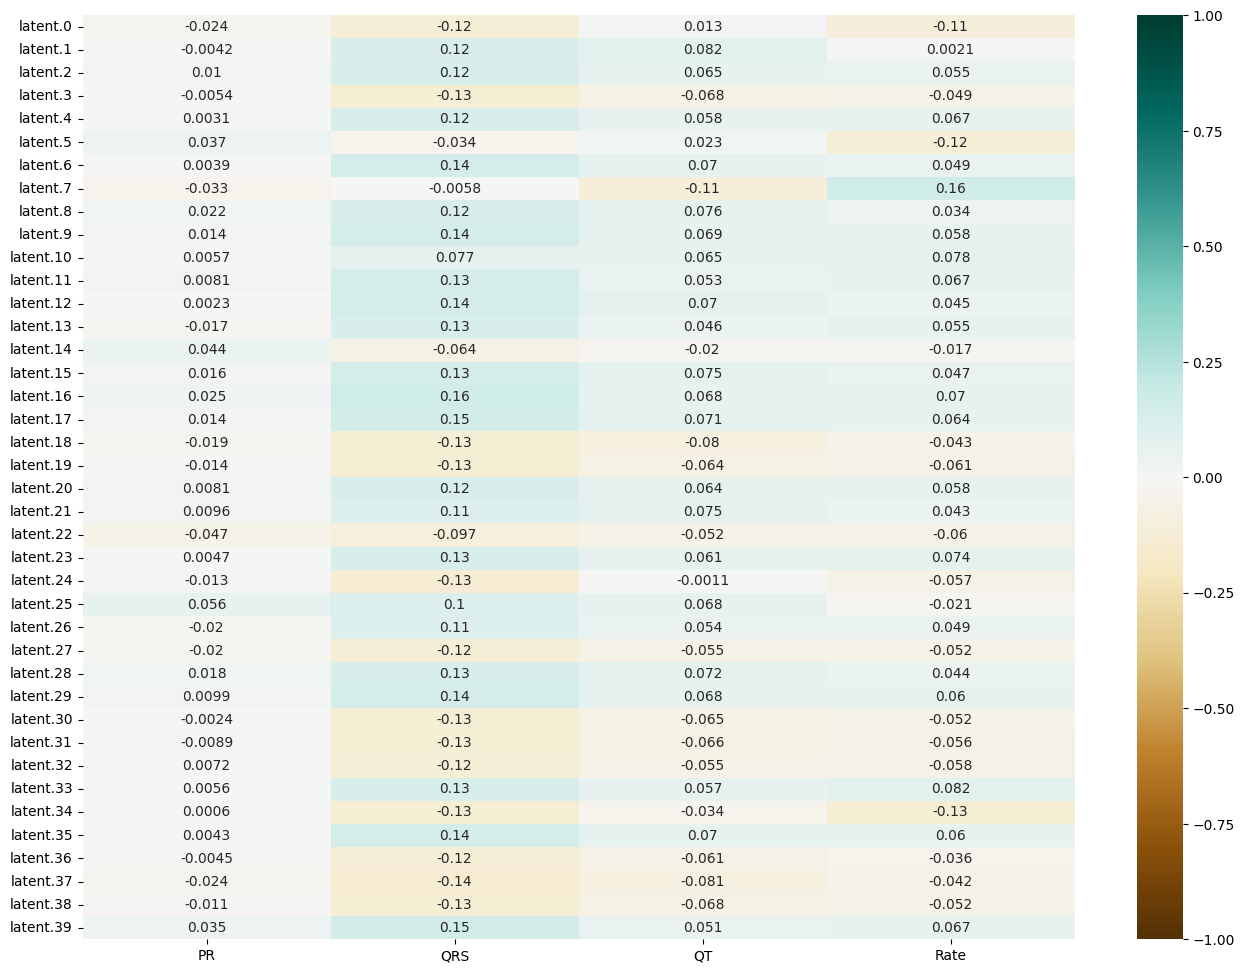

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))

sns.heatmap(correlation_df.corr().loc[[f"latent.{x}" for x in range(0, 40)], ['PR', 'QRS', 'QT', 'Rate']], annot=True, vmin=-1, vmax=1, cmap="BrBG")
